# Getting the data: handwritte numbers

In [1]:
#General dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load the data
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
#DESCR key describes the dataset
#data key contains an array with one row per instance and one column per feature
#target key contains an array with the labels
#mnist['DESCR']

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape) #(70000, 784) 70000 images of 28x28 pixels: 28^2 = 784 
print(y.shape)

(70000, 784)
(70000,)


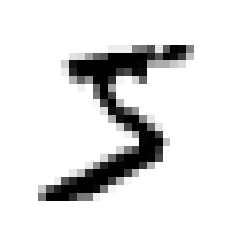

In [5]:
#Plot a number:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
#is it a 5?
print(y[0])

5


In [5]:
#the labels are strings, it would be nice to have numbers...
y = y.astype(np.uint8)

In [6]:
#from the description: 
#"It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples"

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

###### The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

# Training a binary classifier with SGD

In [9]:
#To simplify, let's create a number '5' detector
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

#Stochastic Gradient Descent (SGD)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=43)
sgd_clf.fit(X_train, y_train_5)

print(sgd_clf.predict([some_digit])) #it's a 5!

[ True]


# Performance measure

### With cross-validation

In [10]:
from sklearn.model_selection import cross_val_score

#where cv is the number of folds used
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

[0.9629  0.96655 0.9638 ]


In [11]:
#Really good accuracy
#but what if we guess that it's never a 5:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()

#well, around the 10% of the data are 5s, never picking up a 5 is correct 9 of 10 times
print(cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

[0.91125 0.90855 0.90915]


##### This is why accuracy is not the preferred measure

### Confusion Matrix
##### Count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

In [12]:
#set of predictions so that they can be compared to the actual targets
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
#instead of returning the evaluation scores, returns the predictions made on each test fold

In [13]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train_5, y_train_pred))

[[53756   823]
 [ 1312  4109]]


In [14]:
#-------------------------------------------   ----------------------------------
#| non-five -> non-five | non-five -> five |   | true negative  | false positive|
#| five     -> non-five | five     -> five |   | false negative | true positive |
#-------------------------------------------   ----------------------------------

$precision = \frac{TP}{TP+FP}$

$recall = \frac{TP}{TP+FN}$

In [15]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) #probability of being a five if it's classified as a five
print(recall_score(y_train_5, y_train_pred))    #probability of detect a five

0.8331305758313058
0.7579782327983767


A way to combine this two metrics is using their harmonic mean. This way, lower values have more weight:
To achieve a high score, precision and recall have to be high:

$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2\frac{precision x recall}{precision+recall} = \frac{TP}{TP+\frac{FN+FP}{2}}$

In [16]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7937795807978364


Precision/recall trade-off:

    You cannot increase both of them at the same time.
    If you decide to accept as true positives only those that fits perfectly, you will have a precision of a       100%, but the recall will be low.
    On the other hand, being permissive with the acceptance criteria will increase the recall (almost all samples are true), but the precision will be very low, not only the actual positives are label as true.

In [17]:
#instead of using predict(), decision_function() returns the score, then a treshold has to be selected
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[1633.17856965]
[ True]


In [18]:
#how to decide which treshold to use?
#cross_val_predict() function gets the scores of all instances in the training set
#this time specify that you want to return decision scores instead of predictions

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [19]:
#With these scores, use the precision_recall_curve() function to compute
#precision and recall for all possible thresholds:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

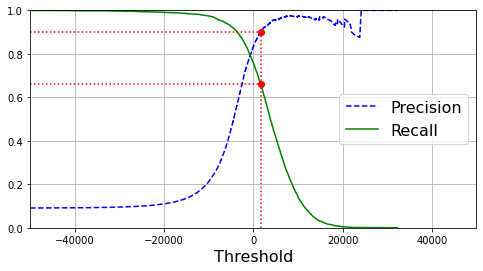

In [20]:
#plot
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                     
plt.show()

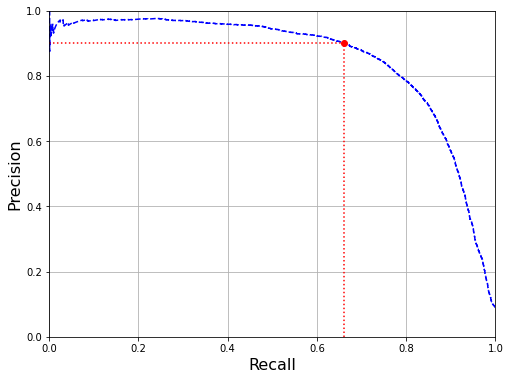

In [21]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--")
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.grid(True)                              
    plt.axis([0, 1, 0, 1])            

precision_90 = precisions[np.argmax(precisions >= 0.90)]
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., precision_90], "r:")
plt.plot([0.0, recall_90_precision], [precision_90, precision_90], "r:")
plt.plot([recall_90_precision], [precision_90], "ro")
plt.show()

In [22]:
#let's assume we want a precision of 90% => recall of recall_90_precision:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

#Even with a precision of 90%, the recall is around 2/3
#There's room for improvement

0.9000753201104695
0.6613171001660211


### The ROC Curve

The receiver operating characteristic plots the true positive rate (another name for recall) against the false positive rate (FPR)

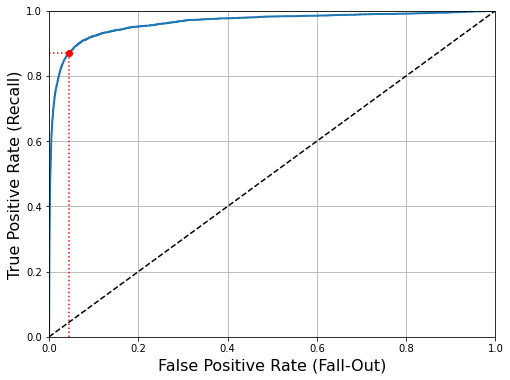

In [119]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

fpr_90 = fpr[np.argmax(tpr >= 0.87)]
tpr_90 = tpr[np.argmax(tpr >= 0.87)]
    
plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([fpr_90, fpr_90], [0.0, tpr_90], "r:")
plt.plot([0.0, fpr_90], [tpr_90, tpr_90], "r:")
plt.plot([fpr_90], [tpr_90], "ro")              
plt.show()

In [24]:
#The higher the recall, the most false positives the classifier produces
#The diagonal curve represents the ROC curve of a purely random classifier
#A good classifier stays as far from that one as possible (top left corner)

#To compare classifiers we can compare the area under the curve (AUC)
#A perfect classifier will have a ROC AUC equal to 1, 
#whereas a purely random classifier will have a ROC AUC equal to 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

#A lot better than the PR magnitude
#This is because the positive class is around the 10% of the samples

0.9635950398529254

##### Which to use? Precision vs. Recall (PR) or TPR vs FPR (ROC)?
That depends, IF the possitive class is rare or False Positives are more important than False Negatives -> PR

Otherwise -> ROC

# Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)


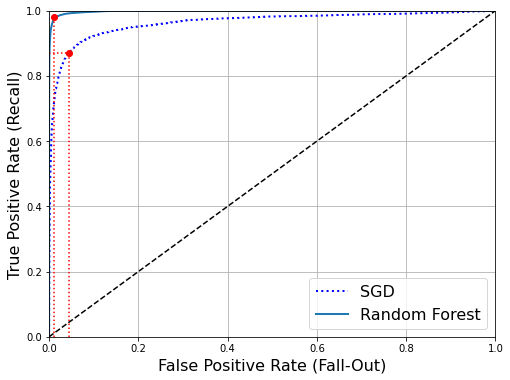

In [127]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([fpr_90, fpr_90], [0.0, tpr_90], "r:")
plt.plot([0.0, fpr_90], [tpr_90, tpr_90], "r:")
plt.plot([fpr_90], [tpr_90], "ro")    

plt.plot([1e-2, 1e-2], [0., 0.98], "r:")
plt.plot([1e-2], [0.98], "ro")
plt.grid(True)

plt.legend(loc="lower right", fontsize=16)
plt.show()

In [26]:
print(roc_auc_score(y_train_5, y_scores_forest))

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

#Much better classificator

0.9983436731328145
0.9905083315756169
0.8662608374838591


# Multiclass classification

One way to achieve this is to create ten binary classifiers, run each one of them per input and select whose score is the highest. This is called One Versus the Rest (OVR) strategy.

Another strategy is to train One Versus One (OVO) classifiers. For N classes you will need Nx(N-1)/2 classifiers. After running each one of them, you pick whose won most duels. The main advantage is that each classifier has to be trained only for two classes. Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets

In [ ]:
#Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task,
#and it automatically runs OvR or OvO, depending on the algorithm.
#Let’s try this with a Support Vector Machine classifier

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

In [129]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(svm_clf.classes_)
print(svm_clf.classes_[np.argmax(some_digit_scores)])

[[ 2.81585438  7.09167958  3.82972099  0.79365551  5.8885703   9.29718395
   1.79862509  8.10392157 -0.228207    4.83753243]]
[0 1 2 3 4 5 6 7 8 9]
5


In [31]:
#Multiclass SGD
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))
print(sgd_clf.decision_function([some_digit]))

[5]
[[-33088.79384069 -27918.7618197  -12448.51881789   -185.8380577
  -27615.83846365   6859.76366877 -24000.69970261 -11544.65996835
   -5204.36251823 -10775.95441337]]


In [32]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86412717, 0.87704385, 0.85617843])

In [33]:
#With a scaler:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90046991, 0.89364468, 0.90018503])

# Error Analysis

In [ ]:
#Using the confusion matrix, actually a plot of it:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
#Most of the values are in the main diagonal, which means they where classified as True Possitives
#Take into consideration that if a class is much less common than the others, even if its Precision is of a 100%,
#it's going to be darker

#Checking the errors:
# divide each value in the confusion matrix by the number of images in the corresponding class to work with 
#Error rates:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

#Fill the diagonal with zeros to work with errors:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows: classes
Columns: classifications

In these case, the 8 column is very bright. This means that several inputs are misclassified as 8s. But the 8 row is not that bad, this is because most 8s are correctly interpretated.

Another thing to remark is that 3s and 5s are often mixed (in both directions).

# K-Nearest Neighbors Classifier

Let's try out this classifier and attempt to get a better accuarcy. How many centroids should we use and what kind of weight is better for this task? A grid search for hyperparameter tunning will let us know.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

accuracy_scorer = make_scorer(accuracy_score)

param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6, 7],
              'n_jobs': [-1]},]
#'uniform' means each sample has the same weight as the others, while 'distance' make the nearest to a centroid
#to be more important than those that are far. By default the model uses five centroids, we are going to try 3, 4,
#5, 6 and 7. 'n_jobs' indicates how many processors are going to be used, -1 means all of them!
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5,
                           scoring=accuracy_scorer)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

y_knn_pred = knn_clf.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_pred)